In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from hydra import initialize, compose
from rdkit import Chem
from collections import defaultdict
from itertools import accumulate
from ergochemics.mapping import rc_to_nest, get_reaction_center
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
from cgr.ml import sep_aidx_to_bin_label
import yaml
from ast import literal_eval
import json

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

from sklearn.calibration import CalibrationDisplay

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

mlflow.set_tracking_uri(f"file://{cfg.mlruns}")

In [2]:
def get_min_dist_to_rc(am_rxn: str, rc: list[list[list[int]], list[list[int]]]) -> list[list[list[int]], list[list[int]]]:
    mols = [[Chem.MolFromSmiles(elt) for elt in side.split('.')] for side in am_rxn.split('>>')]
    min_dists = [[], []]
    for i, side_rc in enumerate(rc):
        for mol, rc in zip(mols[i], side_rc):
            for atom in mol.GetAtoms():
                aidx = atom.GetIdx()
                min_dist = min(len(Chem.GetShortestPath(mol, aidx, rcidx)) - 1 if aidx != rcidx else 0 for rcidx in rc)

                min_dists[i].append(min_dist)
    return [np.array(elt).reshape(-1, 1) for elt in min_dists]


In [3]:
experiment_name = "calib" # outer_splits
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
else:
    print(f"Experiment '{experiment_name}' not found.")

In [4]:
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_loss,metrics.test_loss,metrics.epoch,metrics.test_auprc,...,params.calibration_fraction,params.experiment_name,params.data/inner_splitter/random_state,params.init_lr,tags.source,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.git.commit,tags.mlflow.runName,tags.mlflow.source.type
0,d7fa6e3b8de84f8786446384833b60cd,851245110185084303,FINISHED,file:///home/stef/cgr/artifacts/mlruns/8512451...,2025-07-18 19:59:36.526000+00:00,2025-07-18 20:01:08.454000+00:00,0.396740,0.307125,40.0,0.914961,...,0.15,calib,1234,0.0001,train.py,/home/stef/cgr/scripts/train.py,stef,11eee14c2b0b448347e01e6832225e0fc8ef22d4,salty-wasp-640,LOCAL
1,b539bfe4642141ab983828d98938c5fc,851245110185084303,FAILED,file:///home/stef/cgr/artifacts/mlruns/8512451...,2025-07-18 19:54:27.943000+00:00,2025-07-18 19:56:08.620000+00:00,0.389195,0.299179,40.0,0.913320,...,None,None,None,0.0001,train.py,/home/stef/cgr/scripts/train.py,stef,11eee14c2b0b448347e01e6832225e0fc8ef22d4,magnificent-fox-76,LOCAL
2,e0f39b43daf143698ab4a38267d5fb36,851245110185084303,FAILED,file:///home/stef/cgr/artifacts/mlruns/8512451...,2025-07-18 19:40:00.787000+00:00,2025-07-18 19:41:29.876000+00:00,0.401370,0.301544,40.0,0.912452,...,None,None,None,0.0001,train.py,/home/stef/cgr/scripts/train.py,stef,11eee14c2b0b448347e01e6832225e0fc8ef22d4,crawling-panda-241,LOCAL
3,b010efbd50f242c4b81fb708cccbac66,851245110185084303,FAILED,file:///home/stef/cgr/artifacts/mlruns/8512451...,2025-07-18 19:33:49.384000+00:00,2025-07-18 19:35:17.225000+00:00,0.392316,0.306423,40.0,0.914203,...,None,None,None,0.0001,train.py,/home/stef/cgr/scripts/train.py,stef,11eee14c2b0b448347e01e6832225e0fc8ef22d4,beautiful-cat-626,LOCAL


In [5]:
# Copy configs to conf dir to train production model
for i, row in df.iterrows():
    fn = f"outer_split_{row['params.data/outer_split_idx']}.yaml"
    out_path = Path(cfg.configs) / "full" / fn

    config = defaultdict(dict)
    for k, v in row.items():
        if k.startswith("params.") and "/" in k:
            k_out, k_in, *_ = k.removeprefix("params.").split("/")
            try:
                config[k_out][k_in] = literal_eval(v)
            except ValueError:
                config[k_out][k_in] = v


    with open(out_path, "w") as f:
        yaml.dump(dict(config), f)
    
    print(f"Saving config to: {out_path}")

Saving config to: /home/stef/cgr/configs/full/outer_split_0.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_1.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_2.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_3.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_4.yaml


In [6]:
df.sort_values(
    by=["metrics.test_auprc"],
    ascending=False,
    inplace=True,
)
df[[*[col for col in df.columns if col.startswith("metrics.") or col.startswith("params.")]]].head(10)

,metrics.test_loss,metrics.test_recall,metrics.test_acc,metrics.epoch,metrics.test_precision,metrics.test_auprc,metrics.test_auroc,metrics.train_loss,params.data/inner_splitter/random_state,params.data/outer_split_idx,...,params.data/outer_splitter/n_splits,params.training/batch_size,params.study_version,params.pos_weight,params.data/split_strategy,params.data/outer_splitter/_target_,params.max_lr,params.study_name,params.data/outer_splitter/random_state,params.model/featurizer_mode
3,0.119013,0.965295,0.963204,5.0,0.754520,0.948556,0.991205,0.200481,1234,3,...,5,102,0,1.836826004655332,random_rule_split,sklearn.model_selection.GroupKFold,0.0001,outer_split_3_strategy_random_rule_split_obj_v...,1234,PROD_DIFF
0,0.116239,0.790553,0.952870,7.0,0.922377,0.939413,0.979767,0.089376,1234,0,...,5,102,5,0.9027415475617708,random_rule_split,sklearn.model_selection.GroupKFold,0.0001,outer_split_0_strategy_random_rule_split_obj_v...,1234,PROD_DIFF
2,0.110132,0.770664,0.964769,8.0,0.906544,0.912443,0.977716,0.092075,1234,2,...,5,101,0,1.031126781187535,random_rule_split,sklearn.model_selection.GroupKFold,0.0001,outer_split_2_strategy_random_rule_split_obj_v...,1234,PROD_DIFF
4,0.233754,0.808537,0.947999,18.0,0.797780,0.899109,0.971402,0.109731,1234,4,...,5,115,0,2.2957660139676217,random_rule_split,sklearn.model_selection.GroupKFold,0.0001,outer_split_4_strategy_random_rule_split_obj_v...,1234,PROD_DIFF
1,0.160410,0.709589,0.941155,9.0,0.870209,0.876712,0.957251,0.090822,1234,1,...,5,106,0,1.0076400448888634,random_rule_split,sklearn.model_selection.GroupKFold,0.0001,outer_split_1_strategy_random_rule_split_obj_v...,1234,PROD_DIFF


In [7]:
preds = []
for _, row in df[df['params.objective'] == 'val_f1'].iterrows():
    preds.append(
        pd.read_parquet(
            Path(row['artifact_uri'].replace("file:///home/spn1560/coarse-grain-rxns", "..")) / "predictions.parquet"
        )
    )

pred_df = pd.concat(preds, ignore_index=True)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,10,0,0.0,0.352157
1,10,1,1.0,0.936013
2,10,2,1.0,0.665277
3,10,3,0.0,0.665277
4,10,4,1.0,0.922557


In [8]:
full = pd.read_parquet(
    Path(cfg.raw_data) / "mapped_sprhea_240310_v3_mapped_no_subunits_x_mechinformed_rules.parquet"
)
full["template_aidxs"] = full["template_aidxs"].apply(rc_to_nest)
full["reaction_center"] = full["am_smarts"].apply(get_reaction_center) # Get the actual reaction center from the atom mapped reactions
full["min_dist_to_rc"] = full.apply(lambda x: get_min_dist_to_rc(x.am_smarts, x.reaction_center)[0], axis=1) # Get min dist to reaction center for lhs
full["binary_label"] = full.apply(lambda x: sep_aidx_to_bin_label(x.am_smarts, x.template_aidxs)[0], axis=1) # Convert aidxs to binary labels for block mol
full.head()

,rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id,reaction_center,min_dist_to_rc,binary_label
0,1,CC(O)C(O)C(O)C(O)C(=O)O>>O.CC(O)C(O)CC(=O)C(=O)O,[CH3:11][CH:9]([OH:12])[CH:8]([OH:10])[CH:7]([...,[O&D1&v2&H0&0*&!R:1]=[C&D3&v4&H0&0*&!R&z2:2](-...,"(((10, 9, 11, 7, 8, 5, 6),), ((0,), (5, 6, 7, ...",841,"[[[6, 11, 9, 10, 7, 8, 5]], [[0], [9, 8, 10, 6...","[[3], [2], [3], [1], [2], [0], [0], [0], [0], ...","[[0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1...."
1,10,O=P(O)(O)OP(=O)(O)O.CCCCCCCCCCCC(=O)OP(=O)(O)O...,[O:10]=[P:1]([OH:2])([OH:11])[O:3][P:4](=[O:5]...,[*:1](~[O&D1&v2&H1&0*&!R:2])~[*:3]~[*:4](~[O&D...,"(((1, 2, 4, 5, 6, 7, 8), (14, 16, 13)), ((15, ...",632,"[[[8], [14, 13]], [[18, 15], [13]]]","[[4], [3], [4], [4], [2], [1], [2], [2], [0], ...","[[0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1...."
2,100,*C(=O)OCC(COP(=O)(O)OC1C(O)C(OP(=O)(O)O)C(O)C(...,[*:30][C:27](=[O:31])[O:25][CH2:23][CH:22]([CH...,[*:1](~[O&D2&v2&H0&0*&!R:2]-[P&D4&v5&H0&0*&!R:...,"(((15, 16, 17, 19, 13, 14), (0,)), ((13, 14, 1...",813,"[[[16, 17], [0]], [[16], [1, 3]]]","[[12], [11], [12], [10], [9], [8], [7], [6], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
3,10001,Nc1c(NCC(O)C(O)C(O)CO)[nH]c(=O)[nH]c1=O.Cc1cc2...,[NH2:25][c:26]1[c:27]([NH:29][CH2:36][CH:37]([...,[N&D1&v3&H2&0*&!R:1]-[c&D3&v4&H0&0*&R&z1:2]:[c...,"(((0, 1, 2, 3, 13), (1, 2, 3, 4, 5, 12, 11, 9,...",338,"[[[0, 1, 2, 3], [2, 3, 23, 24, 25, 1]], [[0, 1...","[[0], [0], [0], [0], [1], [2], [3], [3], [4], ...","[[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0...."
4,10008,O.O=[N+]([O-])c1ccc(OP(=O)(O)O)cc1>>O=P(O)(O)O...,[OH2:5].[O:14]=[N+:13]([O-:15])[c:12]1[cH:10][...,[O&D0&v2&H2&0*&!R:1].[O&D2&v2&H0&0*&!R:2]-[P&D...,"(((0,), (7, 8, 9, 10, 11)), ((0, 1, 2, 3, 4), ...",585,"[[[0], [11, 8, 9, 7]], [[0, 1, 3, 4], [7]]]","[[0], [6], [5], [6], [4], [3], [2], [1], [0], ...","[[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."


In [9]:
min_dist_map = dict(zip(full["rxn_id"].astype(int), full["min_dist_to_rc"]))
rule_id_map = dict(zip(full["rxn_id"].astype(int), full["rule_id"]))
pred_df["rule_id"] = pred_df["rxn_id"].map(rule_id_map)
pred_df["min_dist_to_rc"] = None
for k, v in min_dist_map.items():
    pred_df.loc[pred_df["rxn_id"] == k, "min_dist_to_rc"] = v.flatten()

pred_df.head()

,rxn_id,aidx,y,y_pred,rule_id,min_dist_to_rc
0,10,0,0.0,0.352157,632,4
1,10,1,1.0,0.936013,632,3
2,10,2,1.0,0.665277,632,4
3,10,3,0.0,0.665277,632,4
4,10,4,1.0,0.922557,632,2


In [10]:
# Due to molecule symmetry and issues with ergochemics.operator_map_reaction

bad_ids = set()
for _, row in full.iterrows():
    templates = row["template_aidxs"][0]
    rcs = row["reaction_center"][0]

    for template, rc in zip(templates, rcs):
        if len(set(rc) - set(template)) != 0:
            bad_ids.add(row["rxn_id"])
print(bad_ids)

{'6020', '16263', '12818', '7054', '6303', '1101', '3707', '8971', '3555', '5872'}


In [11]:
continuous_rxn_ids = []
for _, row in full.iterrows():
    continuous_rxn_ids.append(
        np.repeat(int(row["rxn_id"]), row["binary_label"].shape[0]).reshape(-1, 1)
    )

continuous_rxn_ids = np.vstack(continuous_rxn_ids)

y = np.vstack(full["binary_label"])
min_dist_rc = np.vstack(full["min_dist_to_rc"])
Rs = [0, 1, 2, 3, 4]
rcr_preds = {R: (min_dist_rc <= R).astype(np.int32) for R in Rs}
recall_from_rcr = [recall_score(y, rcr_preds[R]) for R in Rs]
precision_from_rcr = [precision_score(y, rcr_preds[R]) for R in Rs]
recall_from_rcr, precision_from_rcr

([0.5273371670807345,
  0.7103841275908198,
  0.8372800083392693,
  0.9088066158202888,
  0.965305165134905],
 [0.9993415204293287,
  0.6636855004950576,
  0.4980725307206565,
  0.4035082306113948,
  0.33884226960042935])

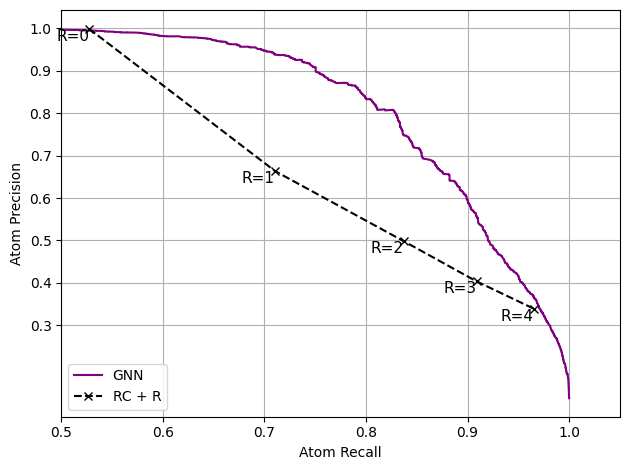

In [12]:
# RC + R stats
r_labels = [f"R={i}" for i in range(len(recall_from_rcr))]

precision, recall, thresholds = precision_recall_curve(pred_df.y, pred_df.y_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple', label="GNN")
ax.plot(recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.set_xticks(np.arange(0.4, 1.05, 0.1))
ax.set_yticks(np.arange(0.3, 1.05, 0.1))
ax.set_xlim(0.5, 1.05)
ax.set_xlabel("Atom Recall")
ax.set_ylabel("Atom Precision")
for r, p, label in zip(recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / "atom_precision_recall_curve.svg", format='svg')
plt.show()

In [13]:
ep = 3e-3
dts = []
for R, prec, rec_rcr in zip(Rs, precision_from_rcr, recall_from_rcr):
    print(f"Precision | {prec:.2f}")
    argequal_prec = np.flatnonzero(np.abs(precision - prec) < ep)[:-1]
    argmax_rec = np.argmax(recall[argequal_prec])
    print(f"Recall | GNN: {recall[argequal_prec][argmax_rec]:.2f} vs RC + {R}: {rec_rcr:.2f}")
    print(f"Threshold | {thresholds[argequal_prec][argmax_rec]:.3f}\n")
    dts.append(float(thresholds[argequal_prec][argmax_rec]))

print(dts)

Precision | 1.00
Recall | GNN: 0.52 vs RC + 0: 0.53
Threshold | 0.983

Precision | 0.66
Recall | GNN: 0.88 vs RC + 1: 0.71
Threshold | 0.156

Precision | 0.50
Recall | GNN: 0.92 vs RC + 2: 0.84
Threshold | 0.062

Precision | 0.40
Recall | GNN: 0.95 vs RC + 3: 0.91
Threshold | 0.036

Precision | 0.34
Recall | GNN: 0.97 vs RC + 4: 0.97
Threshold | 0.022

[0.9828168153762817, 0.15597158670425415, 0.06226504594087601, 0.03628593683242798, 0.021757207810878754]


In [14]:
rxn_recall_from_rcr = []
for R in Rs:
    preds = rcr_preds[R]
    rxn_recovery_indicator = []
    for rxn_id in np.unique(continuous_rxn_ids):
        if (preds[continuous_rxn_ids == rxn_id] - y[continuous_rxn_ids == rxn_id] >= 0).all():
            rxn_recovery_indicator.append(1)
        else:
            rxn_recovery_indicator.append(0)
    
    rxn_recall_from_rcr.append(sum(rxn_recovery_indicator) / len(rxn_recovery_indicator))

rxn_recall = []
ds = 1_000
for dt in thresholds[::ds]:
    rxn_recovery_indicator = []
    for rxn_id, group in pred_df.groupby("rxn_id"):
        preds = (group.y_pred >= dt).astype(np.int32).to_numpy()
        ytrue = group.y.to_numpy()
        if (preds - ytrue >= 0).all():
            rxn_recovery_indicator.append(1)
        else:
            rxn_recovery_indicator.append(0)

    rxn_recall.append(sum(rxn_recovery_indicator) / len(rxn_recovery_indicator))

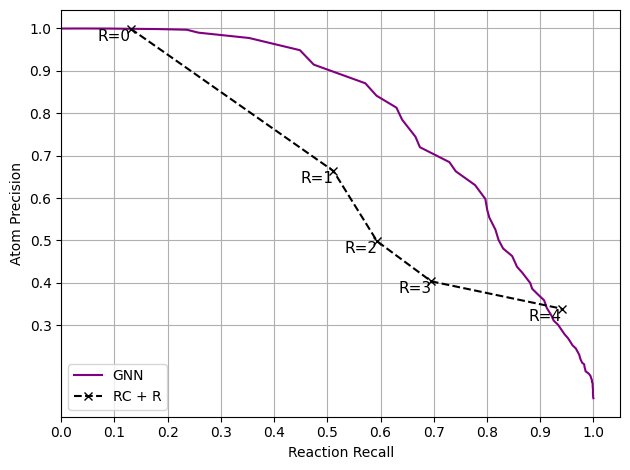

In [15]:
fig, ax = plt.subplots()
ax.plot(rxn_recall, precision[::ds], color='purple', label="GNN")
ax.plot(rxn_recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.set_xticks(np.arange(0.0, 1.05, 0.1))
ax.set_yticks(np.arange(0.3, 1.05, 0.1))
ax.set_xlim(0.0, 1.05)
ax.set_xlabel("Reaction Recall")
ax.set_ylabel("Atom Precision")
for r, p, label in zip(rxn_recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / "atom_precision_reaction_recall_curve.svg", format='svg')
plt.show()

/tmp/ipykernel_142657/430326583.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_R = pred_df.groupby("min_dist_to_rc").apply(


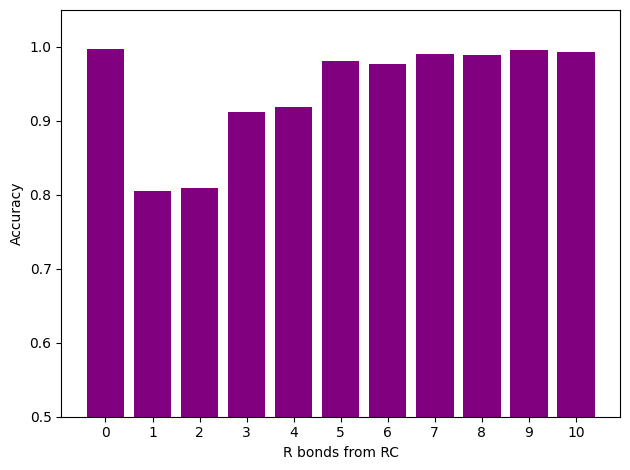

In [16]:
acc_by_R = pred_df.groupby("min_dist_to_rc").apply(
    lambda x: accuracy_score(x.y, x.y_pred >= 0.5)
).iloc[:11]

fig, ax = plt.subplots()
ax.bar(acc_by_R.index, acc_by_R.values, color='purple')
ax.set_xticks(acc_by_R.index)
ax.set_xlabel("R bonds from RC")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.5, 1.05)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / "accuracy_by_R.svg", format='svg')
plt.show()

/tmp/ipykernel_142657/3533828212.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_by_rule = pred_df.groupby("rule_id").apply(


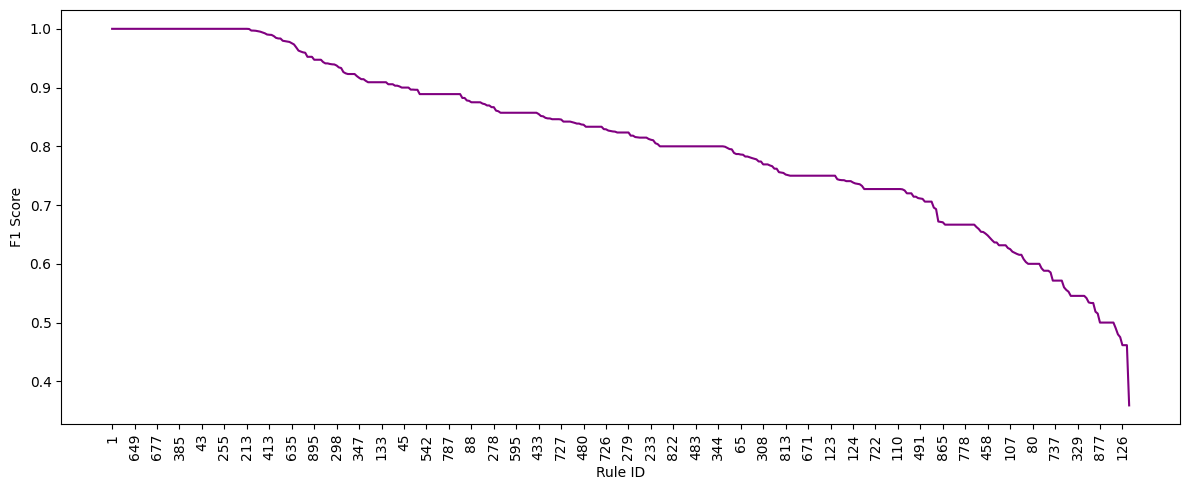

In [17]:
f1_by_rule = pred_df.groupby("rule_id").apply(
    lambda x: f1_score(x.y, x.y_pred >= 0.5)
).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(f1_by_rule.values, color='purple')
ax.set_xticks(np.arange(0, len(f1_by_rule), 10))
ax.set_xticklabels(f1_by_rule.index[::10], rotation=90)
ax.set_xlabel("Rule ID")
ax.set_ylabel("F1 Score")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / "f1_by_mechinformed_rule.svg", format='svg')
plt.show()

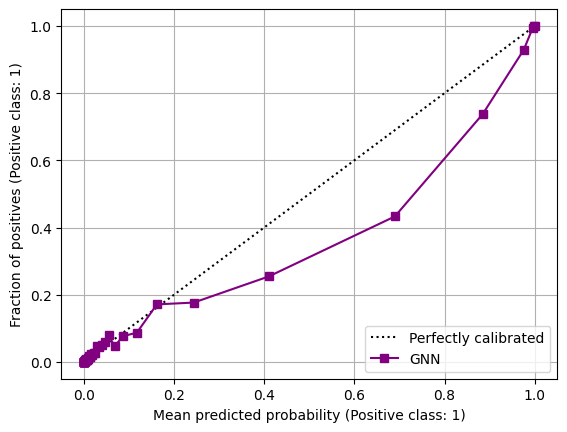

In [18]:
disp = CalibrationDisplay.from_predictions(
    pred_df.y,
    pred_df.y_pred,
    strategy="quantile",
    n_bins=50,
    name="GNN",
    color='purple',
)
plt.grid()
plt.show()

Draw some example reactions

In [19]:
with open(Path(cfg.raw_data) / "sprhea_240310_v3_mapped_no_subunits.json", 'r') as f:
    krs = json.load(f)

rhea_of_i = [
    25250,
    20841,
    15890,
    18618,
    18182
]

krids = set()
for k,v in krs.items():
    if any([elt in v["rhea_ids"] for elt in rhea_of_i]):
        print(f"{k} => rhea: {v["rhea_ids"]}")
        krids.add(k)

164 => rhea: [15890]
641 => rhea: [25250]
1627 => rhea: [18182]
2296 => rhea: [18618]
7561 => rhea: [20841]


REACTION: 2296
left


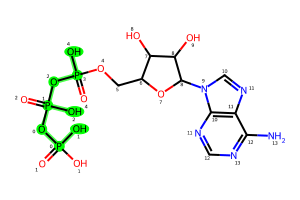

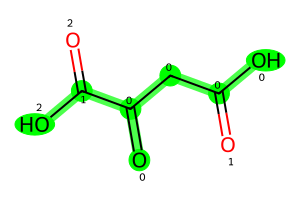

right


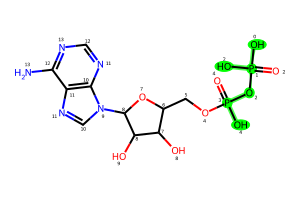

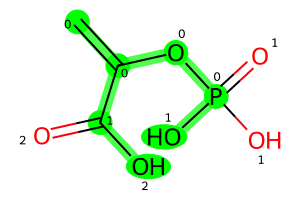

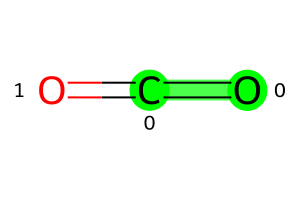

REACTION: 164
left


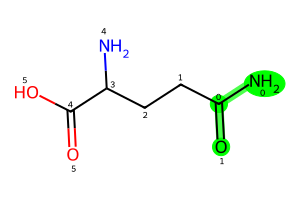

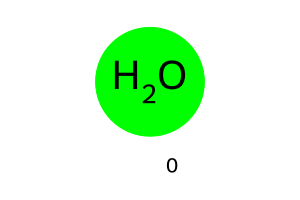

right


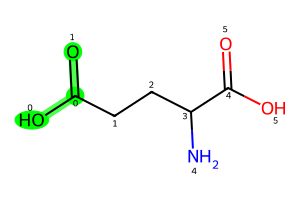

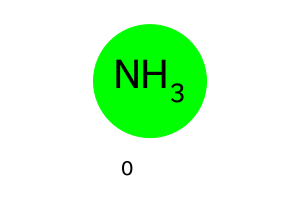

REACTION: 1627
left


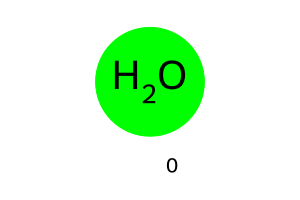

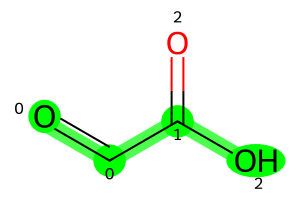

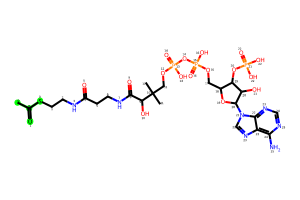

right


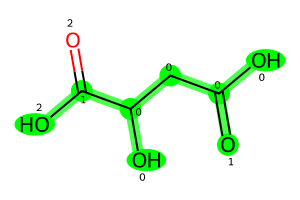

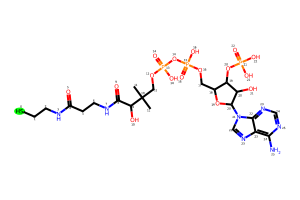

REACTION: 7561
left


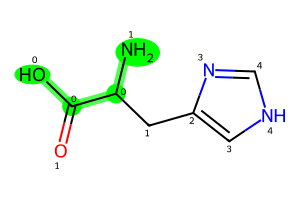

right


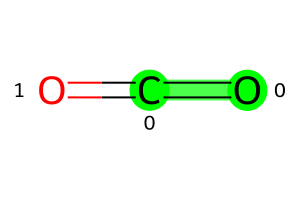

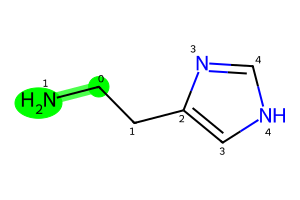

REACTION: 641
left


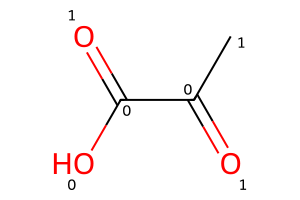

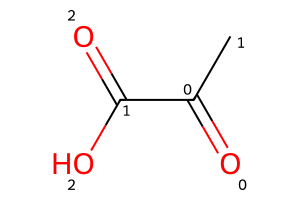

right


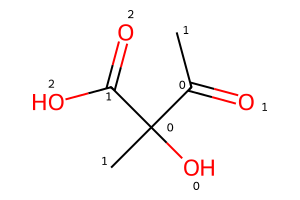

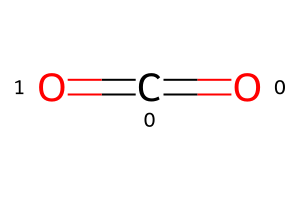

In [23]:
hcolor = (0, 1, 0, 0.7)
sides = ["left", "right"]

for krid in krids:
    row = full.loc[full.rxn_id == krid]
    
    if row.empty:
        print(f"Did not find{ krid}")
        continue

    smarts = row["smarts"].values[0]
    print(f"REACTION: {krid}")
    for side in range(2):
        side_dir = Path(cfg.artifacts) / "imgs" / "mech_overlay" / f"rxn_{krid}" / f"{sides[side]}"
        nh_side_dir = Path(cfg.artifacts) / "imgs" / "mech_overlay" / f"rxn_{krid}" / f"{sides[side]}_no_highlight"
        side_dir.mkdir(parents=True, exist_ok=True)

        print(sides[side])
        smiles = smarts.split('>>')[side].split('.')
        rc = row["reaction_center"].values[0][side]
        mech_template = list(row["template_aidxs"].values[0][side])          
        mols = [Chem.MolFromSmiles(smi) for smi in smiles]
        
        for i in range(len(mols)):
            for atom in mols[i].GetAtoms():
                aidx = atom.GetIdx()
                min_dist_rc = min(
                    len(Chem.GetShortestPath(mols[i], aidx, rcidx)) - 1 if aidx != rcidx else 0 
                    for rcidx in rc[i]
                )
                atom.SetProp("atomNote", f"{min_dist_rc}")
            
            img = draw_molecule(
                mols[i],
                size=(300, 200),
                highlight_atoms=mech_template[i],
                draw_options={'setHighlightColour': hcolor}
            )
            
            with open(side_dir / f"mol_{i}.svg", 'w') as f:
                f.write(img)

            if krid == "641":
                nh_side_dir.mkdir(parents=True, exist_ok=True)
                img = draw_molecule(
                    mols[i],
                    size=(300, 200),
                )

                with open(nh_side_dir / f"mol_{i}.svg", 'w') as f:
                    f.write(img)

            
            display(SVG(img))

In [ ]:
# '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__instance_size__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'addAtomIndices', 'addBondIndices', 'addStereoAnnotation', 'additionalAtomLabelPadding', 'annotationFontScale', 'atomHighlightsAreCircles', 'atomLabelDeuteriumTritium', 'atomLabels', 'atomRegions', 'baseFontSize', 'bondLineWidth', 'bracketsAroundAtomLists', 'centreMoleculesBeforeDrawing', 'circleAtoms', 'clearBackground', 'comicMode', 'continuousHighlight', 'drawMolsSameScale', 'dummiesAreAttachments', 'dummyIsotopeLabels', 'explicitMethyl', 'fillHighlights', 'fixedBondLength', 'fixedFontSize', 'fixedScale', 'flagCloseContactsDist', 'fontFile', 'getAnnotationColour', 'getAtomNoteColour', 'getBackgroundColour', 'getBondNoteColour', 'getHighlightColour', 'getLegendColour', 'getQueryColour', 'getSymbolColour', 'getVariableAttachmentColour', 'highlightBondWidthMultiplier', 'highlightRadius', 'includeAtomTags', 'includeChiralFlagLabel', 'includeMetadata', 'includeRadicals', 'isotopeLabels', 'legendFontSize', 'legendFraction', 'maxFontSize', 'minFontSize', 'multiColourHighlightStyle', 'multipleBondOffset', 'noAtomLabels', 'padding', 'prepareMolsBeforeDrawing', 'reagentPadding', 'rotate', 'scaleBondWidth', 'scaleHighlightBondWidth', 'scalingFactor', 'setAnnotationColour', 'setAtomNoteColour', 'setAtomPalette', 'setBackgroundColour', 'setBondNoteColour', 'setHighlightColour', 'setLegendColour', 'setQueryColour', 'setSymbolColour', 'setVariableAttachmentColour', 'simplifiedStereoGroupLabel', 'singleColourWedgeBonds', 'splitBonds', 'standardColoursForHighlightedAtoms', 'unspecifiedStereoIsUnknown', 'updateAtomPalette', 'useAvalonAtomPalette', 'useBWAtomPalette', 'useCDKAtomPalette', 'useComplexQueryAtomSymbols', 'useDefaultAtomPalette', 'useMolBlockWedging', 'variableAtomRadius', 'variableBondWidthMultiplier'